# task2

### notes

In [1]:
# features that probably will corelate
# temperature
# time of day
# day of week
# weather conditions
# (before) public holiday

# more features
# school/university holidays
# gas prize
# inflation

## Task 2 Predictive Analytics

Import the necessary python libraries

In [207]:
# imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from datetime import datetime
from datetime import timedelta

import math
import random


import seaborn as sns
sns.set()
sns.set_style("white")
#sns.set_palette("GnBu_d")
sns.set_palette("tab10")

### READ DATA

Read bike trip data from csv file

In [208]:
tripdata = pd.read_csv("../boston_2016.csv", encoding = "ISO-8859-1")

# convert datetime type
tripdata['start_time'] = pd.to_datetime(tripdata['start_time'])

In [209]:
# check that import worked
tripdata

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2016-01-01 00:08:07.000,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber
1,2016-01-01 00:08:19.000,2016-01-01 00:40:27,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1121,Subscriber
2,2016-01-01 00:10:15.000,2016-01-01 00:40:29,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,474,Subscriber
3,2016-01-01 00:10:22.000,2016-01-01 00:40:11,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1504,Subscriber
4,2016-01-01 00:15:36.000,2016-01-01 00:31:17,36,67,Boston Public Library - 700 Boylston St.,MIT at Mass Ave / Amherst St,913,Customer
...,...,...,...,...,...,...,...,...
1236198,2016-12-31 23:01:46.254,2016-12-31 23:14:20.6250,8,33,Union Square - Brighton Ave at Cambridge St,Kenmore Square,230,Subscriber
1236199,2016-12-31 23:14:21.233,2016-12-31 23:18:03.1850,190,6,Nashua Street at Red Auerbach Way,Cambridge St at Joy St,1420,Subscriber
1236200,2016-12-31 23:15:38.580,2016-12-31 23:24:43.0190,33,36,Kenmore Square,Copley Square - Dartmouth St at Boylston St,230,Subscriber
1236201,2016-12-31 23:20:35.796,2016-12-31 23:27:58.5830,90,141,Lechmere Station at Cambridge St / First St,Kendall Street,74,Subscriber


Read weather data from csv file

In [210]:
weather_data = pd.read_csv("../weather_hourly_boston.csv", encoding = "ISO-8859-1")

# convert date time type
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

### Organize Data

We set the start and end date because just 2016 data is relevant and create a new dataframe with the seletected data

In [211]:
start = pd.to_datetime(datetime(year=2016, month=1, day=1))
end = pd.to_datetime(datetime(year=2017, month=1, day=1))

# select weather data from 2016
weather_data_16 = weather_data[(weather_data["date_time"]>=start)&(weather_data["date_time"]<=end)]

Organizing the dataframe

In [212]:
# convert precipitation type
weather_data_16['precip'] = weather_data_16['precip'].apply(np.int64)

# sort weather data by timestamp
weather_data_16 = weather_data_16.sort_values(by=['date_time'], ascending=True)

# drop duplicate rows
weather_data_16 = weather_data_16.drop_duplicates(subset='date_time', keep='first')

# reset weather data index
weather_data_16.index = range(8251)

In [213]:
weather_data_16

,date_time,max_temp,min_temp,precip
0,2016-01-01 00:00:00,5.6,5.6,0
1,2016-01-01 01:00:00,5.0,5.0,0
2,2016-01-01 02:00:00,5.0,5.0,0
3,2016-01-01 03:00:00,4.4,4.4,0
4,2016-01-01 04:00:00,4.4,4.4,0
...,...,...,...,...
8246,2016-12-31 20:00:00,1.7,1.7,0
8247,2016-12-31 21:00:00,1.7,1.7,0
8248,2016-12-31 22:00:00,2.2,2.2,0
8249,2016-12-31 23:00:00,3.3,3.3,0


#### Determine most popular station

As we know from Task 1, the most popular rental station by outgoing trips in the network is "MIT at Mass Ave / Amherst St" (station_id: 67).

From now on, for the demand prediction, we focus on the most popular station, so we just look at trips from station 67.

In [214]:
# select just the outgoing trips from station 67
tripdata67 = tripdata.where(lambda x: (x.start_station_id == 67), axis = 0)

# convert start time type
tripdata67['start_time'] = pd.to_datetime(tripdata67['start_time'])

We create a new dataframe with our tripdata, where we count the outgoing trips from statino 67 per hour, drop all other data and adjust the beginning and end times so it is easier to merge the trip data with the weather data later. 

In [215]:
# set hourly Dataframe
tripdata67_hourly = tripdata67.set_index('start_time')

# count outoing trips per hour
tripdata67_hourly = tripdata67_hourly.resample('H').count()

# drop unnecessary columns 
tripdata67_hourly = tripdata67_hourly.drop('start_station_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('end_station_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('start_station_name', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('end_station_name', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('bike_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('user_type', axis=1)
tripdata67_hourly.rename(columns = {'end_time':'trips_out'}, inplace = True)

# reset index
tripdata67_hourly = tripdata67_hourly.reset_index()

# renaming start_time column (to date_time)
tripdata67_hourly.rename(columns = {'start_time':'date_time'}, inplace = True)

# setting index to new range that new data can be added
tripdata67_hourly.index = range(8, 8782)

# create data for 'front' dataframe
data = [[pd.to_datetime('2016-01-01 00:00:00'),0],
        [pd.to_datetime('2016-01-01 01:00:00'),0],
        [pd.to_datetime('2016-01-01 02:00:00'),0],
        [pd.to_datetime('2016-01-01 03:00:00'),0],
        [pd.to_datetime('2016-01-01 04:00:00'),0],
        [pd.to_datetime('2016-01-01 05:00:00'),0],
        [pd.to_datetime('2016-01-01 06:00:00'),0],
        [pd.to_datetime('2016-01-01 07:00:00'),0]]

# create data for 'rear' dataframe
data2 = [[pd.to_datetime('2016-12-31 22:00:00'),0],
         [pd.to_datetime('2016-12-31 23:00:00'),0],
         [pd.to_datetime('2017-01-01 00:00:00'),0]]
 
# create help dataframes
df = pd.DataFrame(data, range(8), columns=['date_time', 'trips_out'])
df2 = pd.DataFrame(data2, range(8782, 8785), columns=['date_time', 'trips_out'])

# add help dataframes to main dataframe
tripdata67_hourly = tripdata67_hourly.append(df, ignore_index=False)
tripdata67_hourly = tripdata67_hourly.append(df2, ignore_index=False)

# sort main dataframe
tripdata67_hourly = tripdata67_hourly.sort_index()

In [216]:
tripdata67_hourly

,date_time,trips_out
0,2016-01-01 00:00:00,0
1,2016-01-01 01:00:00,0
2,2016-01-01 02:00:00,0
3,2016-01-01 03:00:00,0
4,2016-01-01 04:00:00,0
...,...,...
8780,2016-12-31 20:00:00,1
8781,2016-12-31 21:00:00,2
8782,2016-12-31 22:00:00,0
8783,2016-12-31 23:00:00,0


#### MERGE TRIP AND WEATHER DATA

We merge the hourly trip data with the weather data into one dataframe. Afterwards we fill any NaN values that might occur because of missing entries in the weather data.

In [217]:
# create help arrays for column values
data_max = []
data_min = []
data_pre = []

# iterating through dataframe 
# count_w is the current number of columns where we have weather entries
count_w = 0
for i in range(8785):
    # if current timpstamp of trip data and weather data match, add weather values, otherwise add None 
    if tripdata67_hourly['date_time'].iloc[i] == weather_data_16['date_time'].iloc[count_w]:
        data_max.append(weather_data_16['max_temp'].iloc[count_w])
        data_min.append(weather_data_16['min_temp'].iloc[count_w])
        data_pre.append(weather_data_16['precip'].iloc[count_w])
        # if we found weather data, increase weather counter
        count_w = count_w + 1
    else:
        data_max.append(None)
        data_min.append(None)
        data_pre.append(None)

# convert help arrays to series
data_max = pd.Series(data_max)
data_min = pd.Series(data_min)
data_pre = pd.Series(data_pre)

# add new columns to trip data dataframe
tripdata67_hourly['max_temp'] = data_max
tripdata67_hourly['min_temp'] = data_min
tripdata67_hourly['precip'] = data_pre

# iterate through trip data dataframe
for i in range(8785):
    # look for NaN Values and replace them
    if np.isnan(tripdata67_hourly['max_temp'].iloc[i]):
        if np.isnan(tripdata67_hourly['max_temp'].iloc[i+1]):
            tripdata67_hourly['max_temp'].iloc[i] = tripdata67_hourly['max_temp'].iloc[i-1]
            tripdata67_hourly['min_temp'].iloc[i] = tripdata67_hourly['min_temp'].iloc[i-1]
        else:
            tripdata67_hourly['max_temp'].iloc[i] = (tripdata67_hourly['max_temp'].iloc[i-1]+tripdata67_hourly['max_temp'].iloc[i+1])/2
            tripdata67_hourly['min_temp'].iloc[i] = (tripdata67_hourly['min_temp'].iloc[i-1]+tripdata67_hourly['min_temp'].iloc[i+1])/2
        
        tripdata67_hourly['precip'].iloc[i] = tripdata67_hourly['precip'].iloc[i-1]

In [218]:
tripdata67_hourly

,date_time,trips_out,max_temp,min_temp,precip
0,2016-01-01 00:00:00,0,5.6,5.6,0.0
1,2016-01-01 01:00:00,0,5.0,5.0,0.0
2,2016-01-01 02:00:00,0,5.0,5.0,0.0
3,2016-01-01 03:00:00,0,4.4,4.4,0.0
4,2016-01-01 04:00:00,0,4.4,4.4,0.0
...,...,...,...,...,...
8780,2016-12-31 20:00:00,1,1.7,1.7,0.0
8781,2016-12-31 21:00:00,2,1.7,1.7,0.0
8782,2016-12-31 22:00:00,0,2.2,2.2,0.0
8783,2016-12-31 23:00:00,0,3.3,3.3,0.0


#### Add features

We selected a few features that we thought give a good insight into the nature of the bike trip data.

In [223]:
# add average temperature column
tripdata67_hourly['avg_temp'] = (tripdata67_hourly['max_temp'] + tripdata67_hourly['min_temp'])/2

# add weekday column
tripdata67_hourly['weekday'] = tripdata67_hourly.apply(lambda x: (x.date_time.weekday()), axis=1)

# add hour column
tripdata67_hourly['hour'] = tripdata67_hourly.apply(lambda x: (x.date_time.hour), axis=1)

In [224]:
tripdata67_hourly

,date_time,trips_out,max_temp,min_temp,precip,avg_temp,weekday,hour
0,2016-01-01 00:00:00,0,5.6,5.6,0.0,5.6,4,0
1,2016-01-01 01:00:00,0,5.0,5.0,0.0,5.0,4,1
2,2016-01-01 02:00:00,0,5.0,5.0,0.0,5.0,4,2
3,2016-01-01 03:00:00,0,4.4,4.4,0.0,4.4,4,3
4,2016-01-01 04:00:00,0,4.4,4.4,0.0,4.4,4,4
...,...,...,...,...,...,...,...,...
8780,2016-12-31 20:00:00,1,1.7,1.7,0.0,1.7,5,20
8781,2016-12-31 21:00:00,2,1.7,1.7,0.0,1.7,5,21
8782,2016-12-31 22:00:00,0,2.2,2.2,0.0,2.2,5,22
8783,2016-12-31 23:00:00,0,3.3,3.3,0.0,3.3,5,23


# UNWICHTIG ODER?

In [14]:
# eliminate hours with no trips
#tripdata67_hourly = tripdata67_hourly.drop(tripdata67_hourly[tripdata67_hourly.trips_out == 0].index)b

In [221]:
# check if any values in dataframe are Nan
np.any(np.isnan(tripdata67_hourly))

check_for_nan = tripdata67_hourly['avg_temp'].isnull().values.any()
print (check_for_nan)

check_for_nan = tripdata67_hourly['avg_temp'].isnull()
print (check_for_nan)

False
0       False
1       False
2       False
3       False
4       False
        ...  
8780    False
8781    False
8782    False
8783    False
8784    False
Name: avg_temp, Length: 8785, dtype: bool


### Visualization and regression algorithm decision

We visualize a few features to see if the data matches our expectations and if there are any obvious correlations.

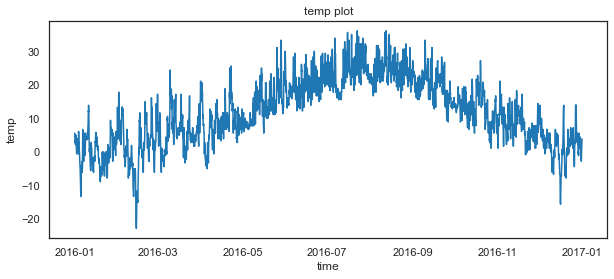

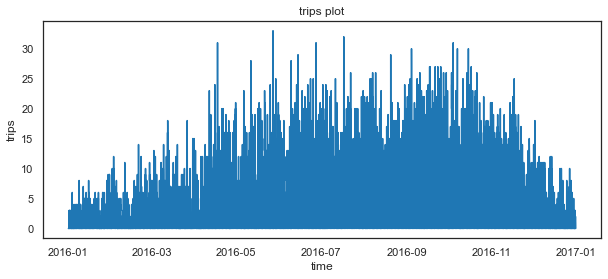

In [227]:
# average temperature visualization
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(tripdata67_hourly["date_time"],tripdata67_hourly["avg_temp"],"-")
ax.set_xlabel("time")
ax.set_ylabel("temp")
ax.set_title("temp plot")

# trips per hours visualization
fig,ax2 = plt.subplots(figsize=(10,4))
ax2.plot(tripdata67_hourly["date_time"],tripdata67_hourly["trips_out"],"-")
ax2.set_xlabel("time")
ax2.set_ylabel("trips")
ax2.set_title("trips plot")

plt.show()

#note: probably correlation of temperature and number of outgoing trips

In [235]:
# define dependent (y) and independent (x) variables for trip demand prediction

xp = tripdata67_hourly["avg_temp"]

yp = tripdata67_hourly["trips_out"]

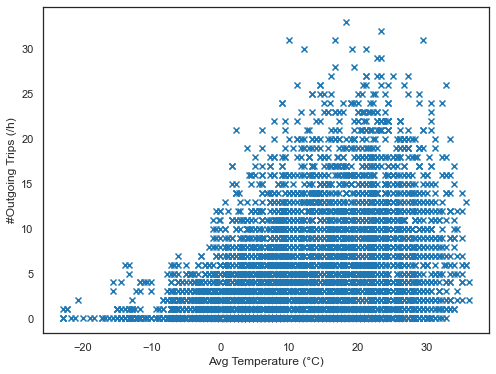

In [236]:
fig, ax = plt.subplots(figsize = (8,6))
# plotting the data
ax.scatter(xp, yp, marker='x',)
ax.set_xlabel("Avg Temperature (°C)")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')
# note: we see that a higher average temperature in an hour correlates with the number of outgoing trips
# (positive trend until +25°C, then negative)

### HOUR OF DAY

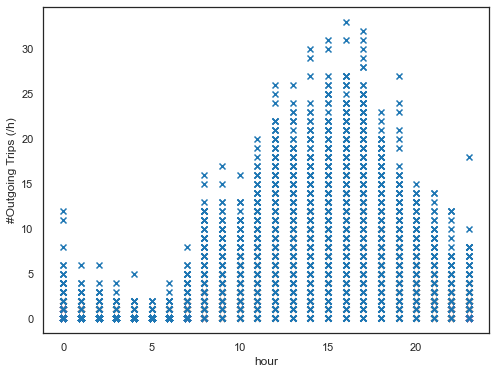

In [237]:
# define dependent (y) and independent (x) variables for trip demand prediction

xp2 = tripdata67_hourly["hour"]

yp2 = tripdata67_hourly["trips_out"]

fig, ax = plt.subplots(figsize = (8,6))
# plotting the data
ax.scatter(xp2, yp2, marker='x',)
ax.set_xlabel("hour")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')
# note: we see that a higher average temperature in an hour correlates with the number of outgoing trips
# (positive trend until +25°C, then negative)

### DAY OF WEEK

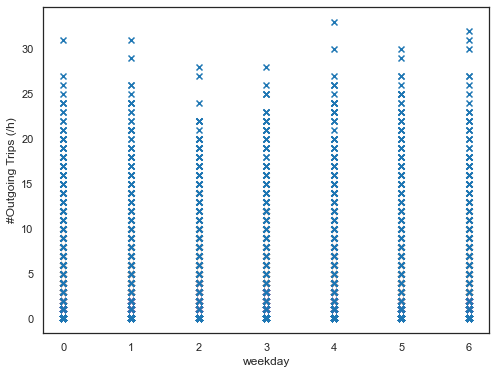

In [238]:
# define dependent (y) and independent (x) variables for trip demand prediction

xp2 = tripdata67_hourly["weekday"]

yp2 = tripdata67_hourly["trips_out"]

fig, ax = plt.subplots(figsize = (8,6))
# plotting the data
ax.scatter(xp2, yp2, marker='x',)
ax.set_xlabel("weekday")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')
# note: we see that a higher average temperature in an hour correlates with the number of outgoing trips
# (positive trend until +25°C, then negative)

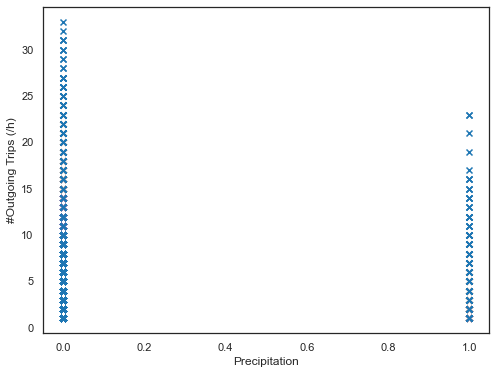

In [62]:
#UNWICHTIG
# define dependent (y) and independent (x) variables for trip demand prediction

xp2 = tripdata67_hourly["precip"]

yp2 = tripdata67_hourly["trips_out"]

#min_H_temp, max_H_temp = xp.min(), xp.max()

fig, ax = plt.subplots(figsize = (8,6))
# Plotting the data
ax.scatter(xp2, yp2, marker='x',)
ax.set_xlabel("Precipitation")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')

In [239]:
# to plot a polynomial regression, we took the code from the workshop

# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    # create scaled test dataset
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # Plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # prints first 3 thetas

[5.20184949 3.16462992]


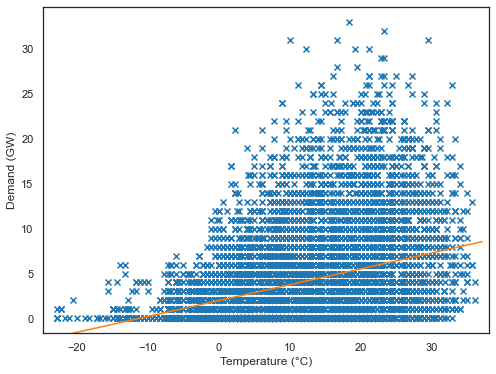

In [240]:
plot_regression_poly(x = xp, y=yp, d = 1)

[0.05836358 5.1826315  3.15975946]


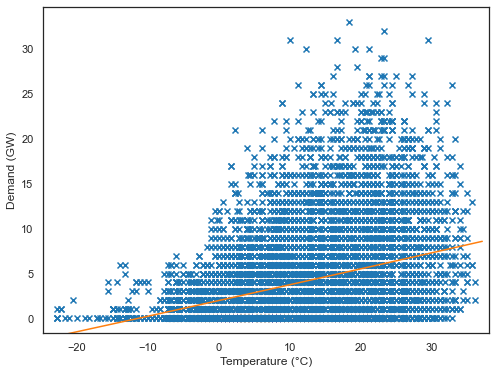

In [241]:
plot_regression_poly(x = xp, y=yp, d = 2)

[-2.4691568   0.9013659   5.76240632  3.09134447]


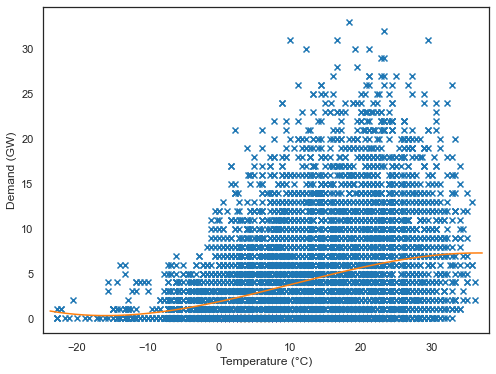

In [242]:
plot_regression_poly(x = xp, y=yp, d = 3)

[-32.63550377  -4.71398058  53.78801811   4.82321407 -26.78751996
   0.16868236   8.19837954]


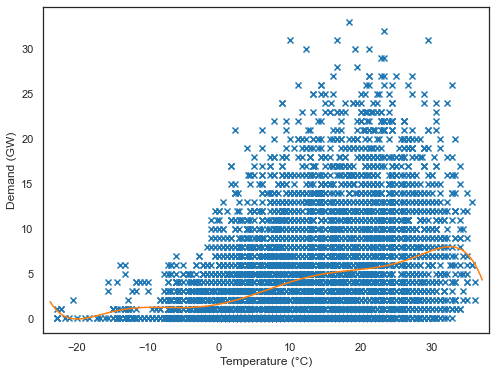

In [243]:
plot_regression_poly(x = xp, y=yp, d = 7)

#### train test split

In [244]:
# splitting the data with 70-30% split
x_train, x_test, y_train, y_test = train_test_split(tripdata67_hourly["avg_temp"], tripdata67_hourly["trips_out"], test_size=0.3, random_state=42)

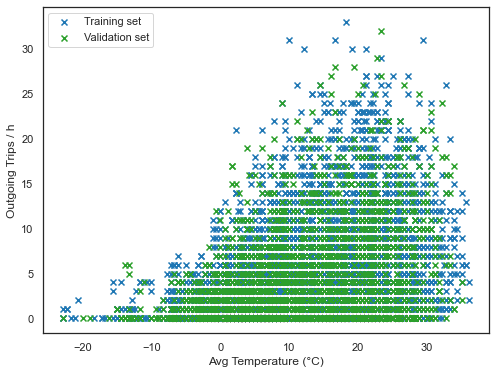

In [245]:
# plotting train and test set
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.xlabel("Avg Temperature (°C)")
plt.ylabel("Outgoing Trips / h")
plt.legend(['Training set', 'Validation set'])
plt.show()
#plt.savefig('crossvalidation.pdf', dpi = 300)

In [246]:
# to determine the mean squared error, we use code from the workshop
def ls_poly(x, y, d): #ls=lest squares
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    
    return theta

Text(0, 0.5, 'Mean squared error')

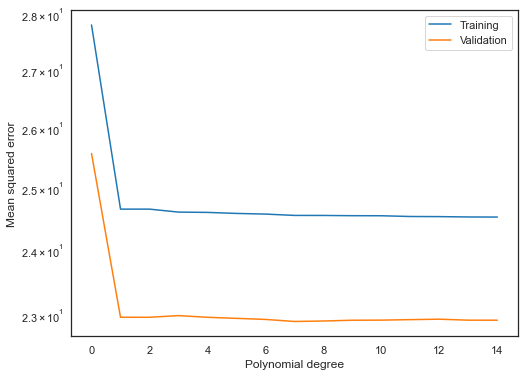

In [247]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_test = 2*(x_test - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    
maxdegree = 15
    
err_train = []
err_cv = []
for i in range(maxdegree):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_test,i) @ theta - y_test)**2).mean())

plt.figure(figsize = (8,6))
plt.semilogy(range(maxdegree), err_train, range(maxdegree), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

### REGULARIZATION

In [ ]:
# because we need quite large polynomial degrees to get accurate results, we decided to use regularization

In [248]:
# a polynomial degree of 35 and a value for lambda of 0.4 seem a good estimate for an accurate prediction
deg = 35
lam = 0.4

xp = tripdata67_hourly["avg_temp"].values
yp = tripdata67_hourly["trips_out"].values

# using mostly code from the workshop to use scikits ridge regression 
# initialize model
Poly = PolynomialFeatures(degree = deg)

# fit and transform xp
X_poly = Poly.fit_transform(xp.reshape(-1,1))

model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver

model_L2.fit(X_poly, yp)
prediction = model_L2.predict(X_poly)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 0.00000000e+00  8.23465635e-02  1.54808106e-03  3.22474439e-05
  4.71089281e-07  7.19432600e-09  2.47117987e-11 -1.25939553e-12
 -8.61782034e-14 -2.57983834e-15 -7.63135113e-17 -1.81218626e-18
 -4.32838145e-20 -8.89432653e-22 -1.78905152e-23 -2.98421589e-25
 -4.31456893e-27 -2.74223545e-29  7.31491589e-31  4.25685626e-32
  1.11045406e-33  1.45302807e-35 -4.72443236e-37 -4.68297448e-38
 -2.48853954e-39 -1.07867906e-40 -4.21864233e-42 -1.54523679e-43
 -5.41265213e-45 -1.83399249e-46 -6.05844988e-48 -1.96125413e-49
 -6.24562634e-51 -1.96196740e-52 -6.09286142e-54 -1.87365629e-55] 
Intercept  2.5246486152036387


In [249]:
# function for plotting

def plot_scikit_output (x, y, fitted_model):
    
    min_x, max_x = x.min(), x.max()
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, fitted_model.predict(xt0_poly), 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Outgoing trips")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)

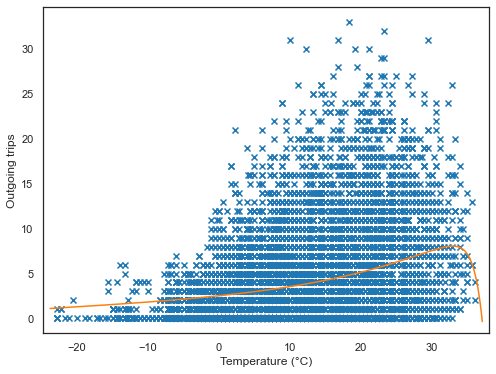

In [250]:
plot_scikit_output (xp, yp, model_L2)

### EVALUTATION

In [125]:
exp1 = -4
exp2 = 5

def plot_L2_regression_performance (x, y, deg):

    err_train = []
    err_cv = []
    
    x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

    for alpha in np.logspace(exp1, exp2,100):

        # create poly features
        poly_reg = PolynomialFeatures (degree = deg)
        X_train_poly = poly_reg.fit_transform(x_train.reshape(-1,1))
        X_test_poly = poly_reg.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L2 = Ridge(alpha = alpha, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test_poly), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(exp1,exp2,100), err_train, np.logspace(exp1,exp2,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

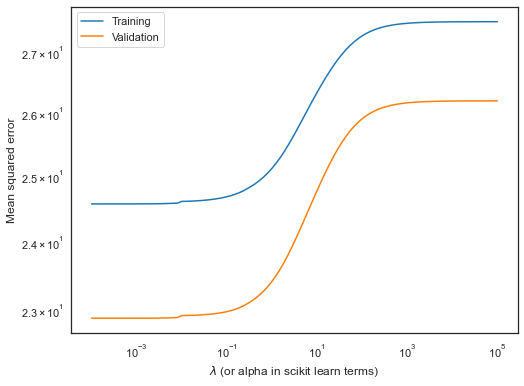

In [126]:
plot_L2_regression_performance(xp,yp,15)

## Radial Basis Function

In [94]:
# for the second regression algorithm we picked the Radial Basis function
# Hyperparameters


In [260]:
# splitting the data with 70-30% split
x_train, x_test, y_train, y_test = train_test_split(tripdata67_hourly["avg_temp"], tripdata67_hourly["trips_out"], test_size=0.3, random_state=42)

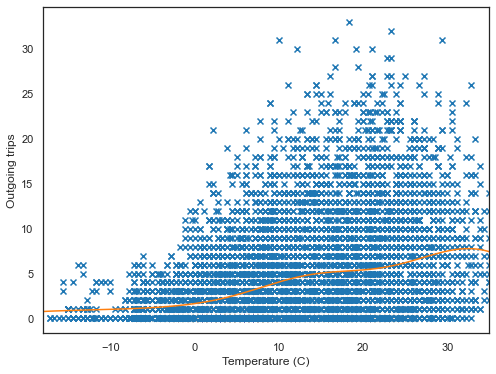

In [265]:

# using code from the workshops to realize the RBF
# create RBF features
def rbf_feat(x, mu, sig):
    return np.hstack([np.exp(-(x[:,None] - mu)**2/(2*sig**2)), np.ones((len(x),1))])

def plot_regression_rbf(theta, mu, sig):
    xt = np.linspace(-20,35, 400)
    yt = rbf_feat(xt, mu, sig) @ theta
    
    plt.figure(figsize = (8,6))
    plt.scatter(tripdata67_hourly["avg_temp"], tripdata67_hourly["trips_out"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt, yt, 'C1')
    plt.xlabel("Temperature (C)")
    plt.ylabel("Outgoing trips")
    plt.xlim([-18,35])
    plt.ylim(ylim)                  

def train_rbf(x, y, n_rbf):
    min_x, max_x = x.min(), x.max()
    sig = (max_x - min_x)/(n_rbf-1)
    mu = np.linspace(min_x, max_x, n_rbf-1)
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi, Phi.T @ y)
    return theta, mu, sig
    
x = tripdata67_hourly["avg_temp"].values
plot_regression_rbf(*train_rbf(xp, yp, 10))

[]

In [ ]:
# note: no need to use regularization to smooth the function

# TO DO: EVALUATION

In [ ]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_test = 2*(x_test - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    
maxdegree = 15
    
err_train = []
err_cv = []
for i in range(maxdegree):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_test,i) @ theta - y_test)**2).mean())

plt.figure(figsize = (8,6))
plt.semilogy(range(maxdegree), err_train, range(maxdegree), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

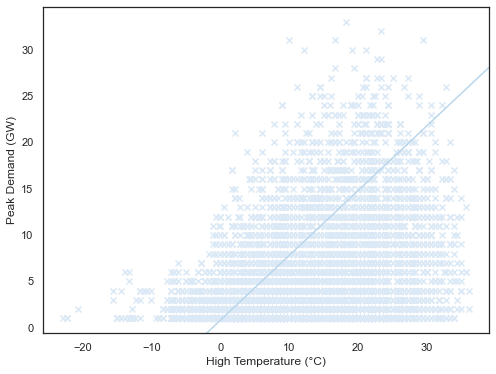

In [283]:
# UNWICHTIG
# define theta vector
theta = np.array([0.7, 0.80])

# set up plot
fig, ax = plt.subplots(figsize = (8,6))

# add objects to axis
ax.scatter(xp, yp, marker='x')
xlimp, ylimp =(plt.gca().get_xlim(), plt.gca().get_ylim())  #gets limity of x and y
ax.plot(xlimp, [theta[0]*xlimp[0]+theta[1], theta[0]*xlimp[1]+theta[1]], 'C1')
ax.set_xlim(xlimp)
ax.set_ylim(ylimp)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
plt.show()
#plt.savefig('summer data_peak demand_line.pdf')

In [242]:
# rescaling
x_nor = (xp-min(xp))/(max(xp)-min(xp))
y_nor = (yp-min(yp))/(max(yp)-min(yp))

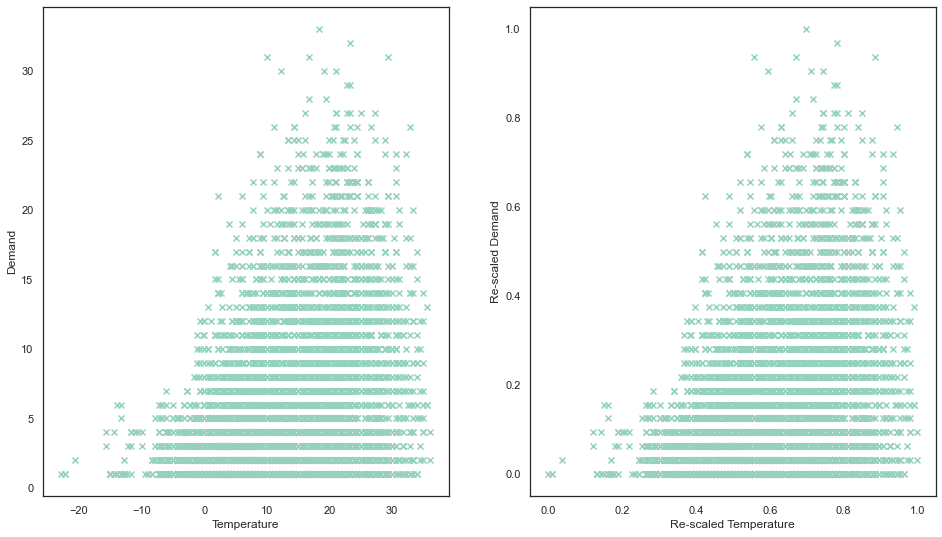

In [243]:
# set up plot
fig, axes = plt.subplots(1,2,figsize = (16,9))

axes[0].scatter(xp, yp, marker='x')
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Demand")

axes[1].scatter(x_nor, y_nor, marker = 'x')
axes[1].set_xlabel("Re-scaled Temperature")
axes[1].set_ylabel("Re-scaled Demand")

plt.show()

In [244]:
theta = np.array([0., 0.])

alpha = 1.0

for t in range(20):
    print("Iteration {}: ".format(t), theta)
    
    # partial derivative theta1: 2*sum(((theta1*x + theta2)-y)*x)
    # term 2/N added here (usully included in alpha term), this is just a constant so could also be omitted
    theta[0] -= alpha/len(xp) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
    
    # partial derivative theta2: 2*sum(((theta1*x + theta2)-y))
    # term 2/N added here (usully included in alpha term), this is just a constant so could also be omitted
    theta[1] -= alpha/len(xp) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) ) # this is the intercept with a slightly different partial derivative

Iteration 0:  [0. 0.]
Iteration 1:  [0.21071427 0.05996378]
Iteration 2:  [0.1814432  0.03559715]
Iteration 3:  [0.20501209 0.03130117]
Iteration 4:  [0.2151191 0.0233058]
Iteration 5:  [0.22693624 0.01693011]
Iteration 6:  [0.2371379  0.01089934]
Iteration 7:  [0.24658545 0.00544075]
Iteration 8:  [0.25518093 0.0004462 ]
Iteration 9:  [ 0.26303556 -0.00411143]
Iteration 10:  [ 0.27020538 -0.00827316]
Iteration 11:  [ 0.27675186 -0.01207274]
Iteration 12:  [ 0.28272879 -0.01554183]
Iteration 13:  [ 0.28818582 -0.01870914]
Iteration 14:  [ 0.29316815 -0.02160094]
Iteration 15:  [ 0.29771707 -0.02424118]
Iteration 16:  [ 0.30187029 -0.02665175]
Iteration 17:  [ 0.30566223 -0.02885263]
Iteration 18:  [ 0.30912432 -0.03086207]
Iteration 19:  [ 0.31228524 -0.0326967 ]


### SCIKITLEARN REGRESSION

[0.18768717] 3.616782170151294


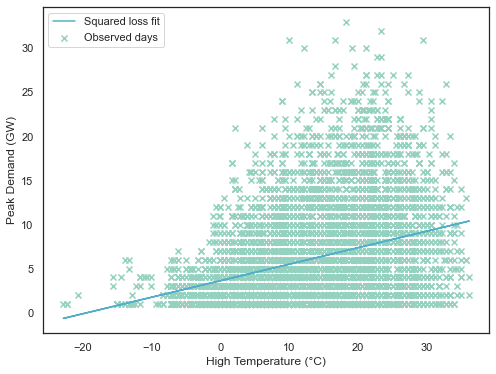

In [245]:
X = tripdata67_hourly["avg_temp"].values.reshape((-1,1)) # if we pass a 1-feature array we need to re-shape it! This is not required for multi-dimenisonal arrays
y = tripdata67_hourly["trips_out"]

# initialize model
lin_mod = LinearRegression()

#train model
lin_mod.fit(X, y)

#make predictions using model
model_pred = lin_mod.predict(X)

# plot resulzts
plt.figure(figsize = (8,6))
plt.scatter(X, y, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(X, model_pred, c='C2')
plt.legend(['Squared loss fit','Observed days'])
print(lin_mod.coef_, lin_mod.intercept_)

# STATION DATA

In [11]:
stationdata = pd.read_csv("../current_bluebikes_stations_new.csv", encoding = "ISO-8859-1")

In [213]:
stationdata

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
422,N32005,West Newton,42.349601,-71.226275,Newton,Yes,15,2020.0
423,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,19,2019.0
424,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
425,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,19,2018.0


In [13]:
stationdata

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
422,N32005,West Newton,42.349601,-71.226275,Newton,Yes,15,2020.0
423,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,19,2019.0
424,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
425,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,19,2018.0


In [ ]:
----------------------------------------------------------------